In [16]:
# Wczytanie danych
import pickle
import gzip
import ast

with open('embeddings2.pkl', 'rb') as f:
    embeddings = pickle.load(f)

# Mapa: identyfikator(asin) -> index
asin_index_map = {}
# zbiór wszystkich identyfikatorów z item_list
item_ids_set = set()
with open('item_list2.txt', 'r') as f:
    next(f)
    for line in f:
        asin, idx = line.strip().split()
        asin_index_map[asin] = int(idx)
        item_ids_set.add(asin)

# Mapa: Asin -> Kategorie
asin_category_map = {}
with gzip.open('meta_Sports_and_Outdoors.json.gz', 'rt', encoding='utf-8') as f:
    for line in f:
        try:
            metadata = ast.literal_eval(line)
        except:
            continue
        asin = metadata.get('asin')
        if asin in item_ids_set:
            categories = metadata['categories']
            asin_category_map[asin] = categories[0]


In [29]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

main_categories = []
# tylko używane indeksy
valid_indices = []
unique_subcats = set()

for asin, idx in asin_index_map.items():
    if asin in asin_category_map:
        categories = asin_category_map[asin]
        if categories:  
            main_categories.append(categories[0])
            subcats = categories[1:] if len(categories) > 1 else []
            unique_subcats.update(subcats)
            valid_indices.append(idx)

filtered_embeddings = embeddings[valid_indices]

# Dla kategorii głównych
X_train, X_test, y_train, y_test = train_test_split(
    filtered_embeddings, main_categories, test_size=0.2, random_state=42
)

for metric_name in ['cosine', 'euclidean']:
    knn = KNeighborsClassifier(metric=metric_name, n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Metryka: {metric_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("---")

# Klasyfikacja podkategorii
X_clean1 = []
y_clean1 = []
for asin, sub_cats in asin_category_map.items():
    filtered_sub_cats = []
    sub_cat = sub_cats[1:]
    for sub in sub_cat:
        if sub in unique_subcats:
            filtered_sub_cats.append(sub)
    
    y_clean1.append(filtered_sub_cats)
    idx = asin_index_map[asin]
    X_clean1.append(embeddings[idx])


mlb = MultiLabelBinarizer()
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_clean1, y_clean1, test_size=0.2, random_state=42
)

y_train_mlb = mlb.fit_transform(y_train_sub)
y_test_mlb = mlb.transform(y_test_sub)

for metric_name in ['cosine', 'euclidean']:
    knn_sub = KNeighborsClassifier(metric=metric_name, n_neighbors=5)
    knn_sub.fit(X_train_sub, y_train_mlb)
    y_pred_sub = knn_sub.predict(X_test_sub)
    
    accuracy = accuracy_score(y_test_mlb, y_pred_sub)
    f1 = f1_score(y_test_mlb, y_pred_sub, average='weighted')
    
    print(f"Metryka: {metric_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("---")



Metryka: cosine
Accuracy: 0.9954
F1-score: 0.9931
---
Metryka: euclidean
Accuracy: 0.9954
F1-score: 0.9931
---


/opt/miniconda3/envs/ml_list2/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Active Protection', 'Air Filter Accessories & Cleaning Products', 'Air Filters & Accessories', 'Bags', 'Batting Helmets', 'Bike Frames', 'Boot Bags', 'Bowling Totes', 'Bridges & Bridge Heads', 'Card Albums', 'Card Boxes', 'Cart Bags', 'Cases & Wallets', "Catcher's Leg Guards", "Children's Roller Skates", 'Chippers', 'Competitor Numbers', 'Corks, Floats & Bobbers', 'Coyote', 'Crampon Accessories', 'Crampons', 'Diving Lights', 'Duffle Bags', 'Elbow & Wrist Protection', 'Elk', 'Fast-Pitch Softballs', 'Field Hockey', 'Filters', 'Fishing Hats', 'Fitness Circles', 'Fletches', 'Football Machines', 'Forks', 'Goalkeeper Helmets', 'Golf Equipment', 'Golf Gear', 'Grip Repair Kits', 'Gym & Competition Equipment', 'Hangers', 'Head Covers', 'Holsters & Clips', 'Hybrid Clubs', 'Ice Axes', 'Kickballs', 'Midrange Discs', 'Outboard Motor Brackets', 'Outboard Motors', 'Paint, B

Metryka: cosine
Accuracy: 0.0621
F1-score: 0.3687
---
Metryka: euclidean
Accuracy: 0.0556
F1-score: 0.3585
---


/opt/miniconda3/envs/ml_list2/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [30]:
# 1 podkategoria
sub_categories3 = []
valid_indices3 = []

for asin, idx in asin_index_map.items():
    if asin in asin_category_map:
        categories = asin_category_map[asin]
        if categories:  
            # main_categories.append(categories[0])
            sub_categories3.append(categories[1] if len(categories) > 1 else None)
            valid_indices3.append(idx)

filtered_embeddings3 = embeddings[valid_indices3]


subcat_data = []
subcat_labels = []

for i, subcat in enumerate(sub_categories3):
    if subcat is not None:
        subcat_data.append(filtered_embeddings3[i])
        subcat_labels.append(subcat)

X_train_sub3, X_test_sub3, y_train_sub3, y_test_sub3 = train_test_split(
    np.array(subcat_data), subcat_labels, test_size=0.2, random_state=42
)

for metric_name in ['cosine', 'euclidean']:
    knn_sub3 = KNeighborsClassifier(metric=metric_name, n_neighbors=5)
    knn_sub3.fit(X_train_sub3, y_train_sub3)
    y_pred_sub3 = knn_sub3.predict(X_test_sub3)
    
    accuracy = accuracy_score(y_test_sub3, y_pred_sub3)
    f1 = f1_score(y_test_sub3, y_pred_sub3, average='weighted')
    
    print(f"Metryka: {metric_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("---")

Metryka: cosine
Accuracy: 0.7025
F1-score: 0.6829
---
Metryka: euclidean
Accuracy: 0.6939
F1-score: 0.6768
---


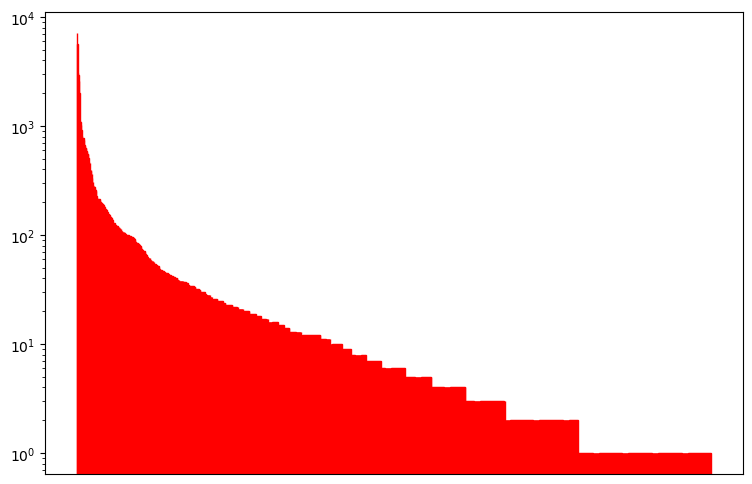

Metryka: cosine
Accuracy: 0.8110
F1-score: 0.8023
---
Metryka: euclidean
Accuracy: 0.8110
F1-score: 0.7942
---


In [23]:
# Spróbujmy teraz wyłonić najczęściej występujące podkategorie i na ich podstawie zrobić 
# multilabelbinarizer
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

sub_category_counter = Counter()

for cat_list in asin_category_map.values():
    if len(cat_list) > 1:
        sub_cats = cat_list[1:]
        sub_category_counter.update(sub_cats)

counts = sub_category_counter.values()
sorted_counts = sorted(counts, reverse=True)
x_axis_index = range(len(sorted_counts))

plt.figure(figsize=(9, 6))
plt.bar(x_axis_index, sorted_counts, color='red', edgecolor='red')
plt.yscale('log')
plt.xticks([])
plt.show()
# Widać że dużo kategorii występuje bardzo rzadko - nie będziemy brać pod uwagę wszystkich

min_occurence = 5000
allowed_categories = set(
    category for category, count in sub_category_counter.items()
    if count >= min_occurence
)

X_clean = []
y_clean = []

for asin, sub_cats in asin_category_map.items():
    filtered_sub_cats = []
    sub_cat = sub_cats[1:]

    for sub in sub_cat:
        if sub in allowed_categories:
            filtered_sub_cats.append(sub)
    
    y_clean.append(filtered_sub_cats)
    idx = asin_index_map[asin]
    X_clean.append(embeddings[idx])

X_train_sub4, X_test_sub4, y_train_sub4, y_test_sub4 = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

mlb4 = MultiLabelBinarizer()
y_train_mlb = mlb4.fit_transform(y_train_sub4)
y_test_mlb = mlb4.transform(y_test_sub4)

for metric_name in ['cosine', 'euclidean']:
    knn_sub4 = KNeighborsClassifier(metric=metric_name, n_neighbors=5)
    knn_sub4.fit(X_train_sub4, y_train_mlb)
    y_pred_sub4 = knn_sub4.predict(X_test_sub4)
    
    accuracy = accuracy_score(y_test_mlb, y_pred_sub4)
    f1 = f1_score(y_test_mlb, y_pred_sub4, average='weighted')
    
    print(f"Metryka: {metric_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("---")